## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_horizontal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2006,
 3: 8024,
 4: 32096,
 5: 128384,
 6: 513536,
 7: 2054144,
 8: 8216576,
 9: 32866304}

Running 12760 CDFs


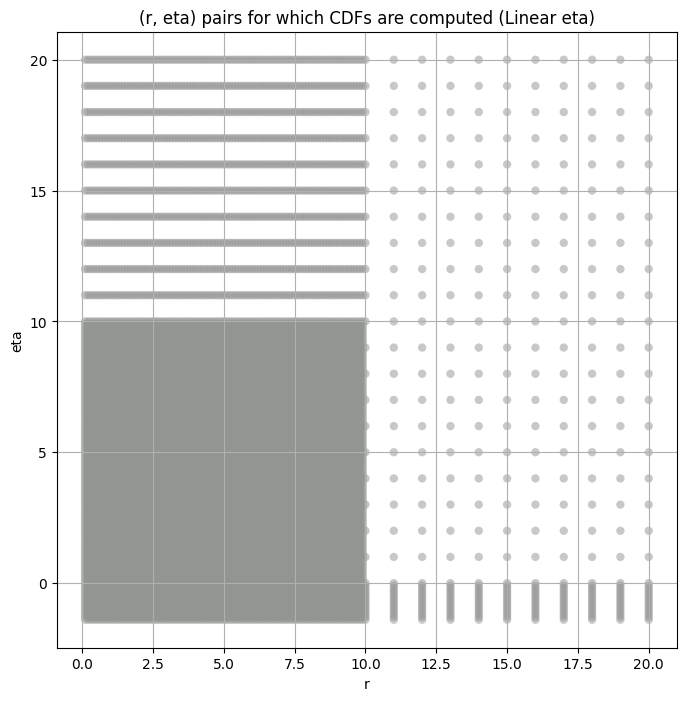

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8463.985000  7577.499500  9384.216000   1.476042    0.959262   
3      1697.862400  1595.025000  1803.665600   2.565592    2.200481   
4       332.164900   311.214750   353.687930   4.184177    3.650794   
5        64.065840    59.352590    68.908600   6.430954    5.621179   
6        12.431011    11.384822    13.536140   9.384012    8.105215   
7         2.503288     2.262330     2.758165  12.938325   10.949556   
8         0.586599     0.525955     0.650404  14.809818   12.432942   
9         0.195002     0.176042     0.215174  13.231615   11.041210   

       kurt_upper  total_samples  
layer                             
2        2.113501           2006  
3        2.955890           8024  
4        4.750882          32096  
5        7.308013         128384  
6       10.801366         513536  
7       15.221071        2054144  
8       17.457571        8216576  
9       15.557378       32866304

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      8463.985000    8463.985352     6644.865234     5587.203613   
3      1697.862400    1697.862427     1536.168091     1427.692627   
4       332.164900     332.164886      318.894653      308.590363   
5        64.065840      64.065842       62.803020       61.781998   
6        12.431011      12.431011       12.111617       11.857983   
7         2.503288       2.503288        2.420080        2.356928   
8         0.586599       0.586599        0.564965        0.548283   
9         0.195002       0.195002        0.188250        0.182858   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         4822.394531      4228.985840      3262.359375      2586.399658   
3         1339.247437      1261.018799      1131.929443      1026.960938   
4          299.908844       292.239410       278.602417       266.783447   
5           60.860870        60.011101        58.466190        57.096588   
6           11.632910        11.427883        11.061025        10.734191   
7            2.301514         2.251527         2.162883         2.085375   
8            0.533831         0.520876         0.498125         0.478392   
9            0.178164         0.173961         0.166612         0.160279   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          2078.415771      1668.691284      1333.088013       660.537231  
3           938.927673       861.093201       793.864990       629.866882  
4           256.238220       246.551056       237.508698       213.835739  
5            55.839840        54.670952        53.575069        50.636112  
6            10.438063        10.164756         9.911368         9.245201  
7             2.015813         1.952481         1.894161         1.742247  
8             0.460832         0.444992         0.430533         0.393294  
9             0.154690         0.149678         0.145133         0.133541

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.045379624631276094 8463.985


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.04726675636572564 6644.865


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.05809748425027761 5587.2036


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.07141259532930311 4822.3945


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.08501056309120669 4228.986


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10865231492591343 3262.3594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.1324738439026738 2586.3997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.1552532857252995 2078.4158


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.17557324812003738 1668.6913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.19602697760528953 1333.088


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2587234891888054 660.53723
Number of samples: 2006, Without approximation : 2006


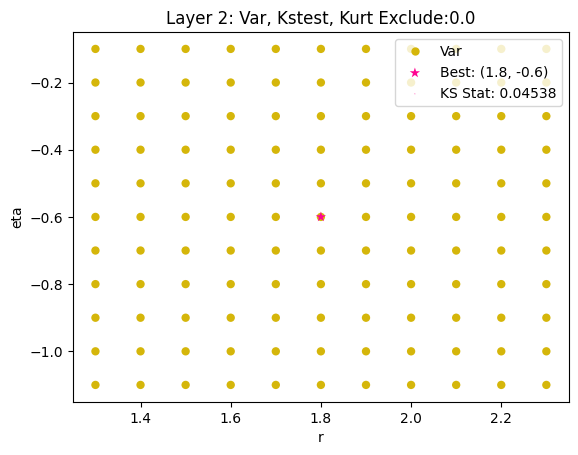

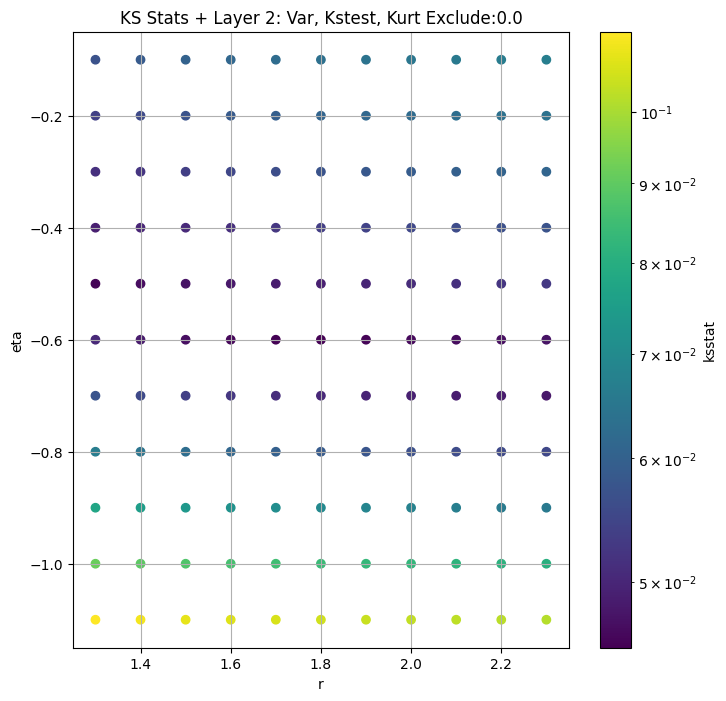

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.04355311126438233 1697.8624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.043579318486223984 1536.1681


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.04357212452371162 1427.6926


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.04358462006504288 1339.2474


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.04361108426186605 1261.0188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.04580251356272025 1131.9294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.04850848721785617 1026.9609


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.05271345474991734 938.9277


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.058839287555222275 861.0932


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06523658911321129 793.865


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08323478201415402 629.8669
Number of samples: 8024, Without approximation : 8024


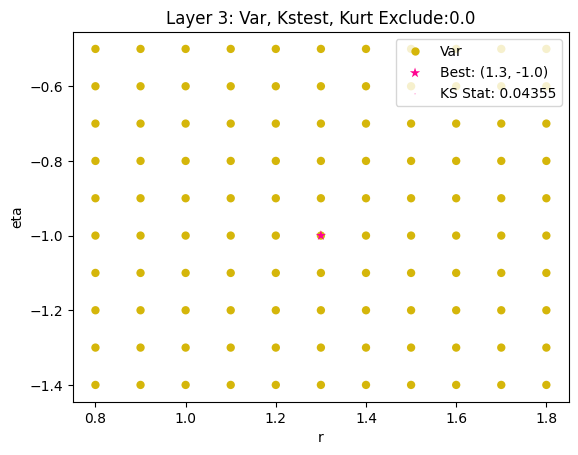

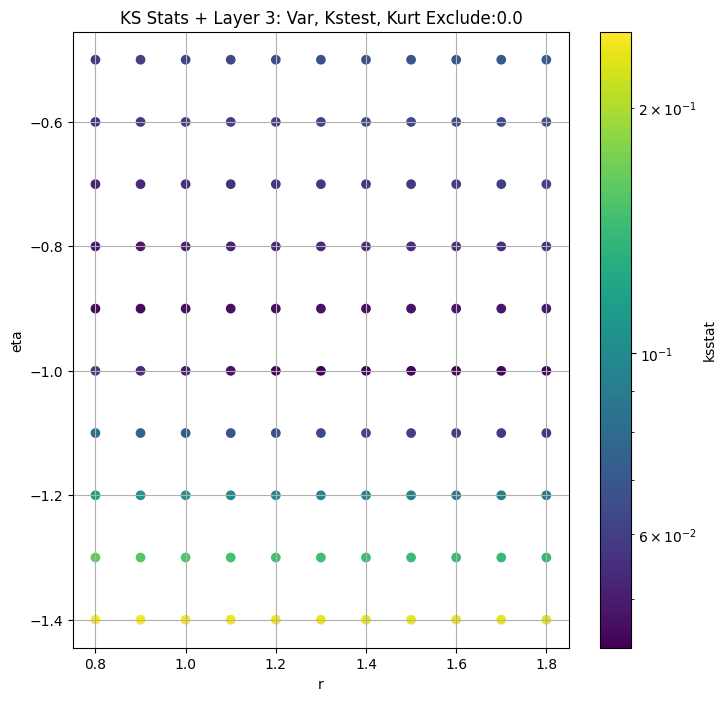

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03585653236437625 332.1649


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.035856947030191266 318.89465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.03585584535571151 308.59036


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.035856186095931164 299.90884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.035856285132129795 292.2394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.035855999634610336 278.60242


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.035855806975356286 266.78345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.035855511864019196 256.23822


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.03623520368474259 246.55106


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.037553470967523095 237.5087


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.037594718907181135 213.83574
Number of samples: 32096, Without approximation : 32096


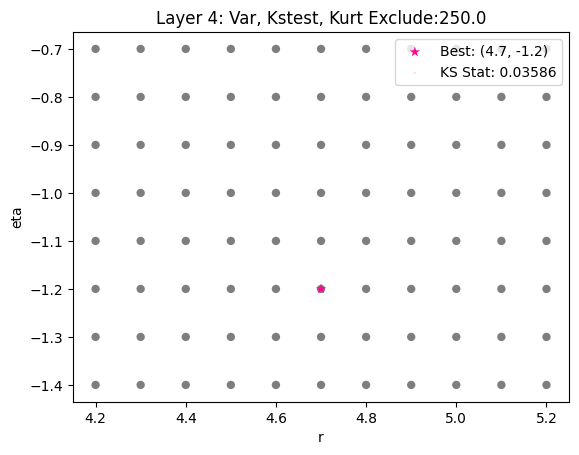

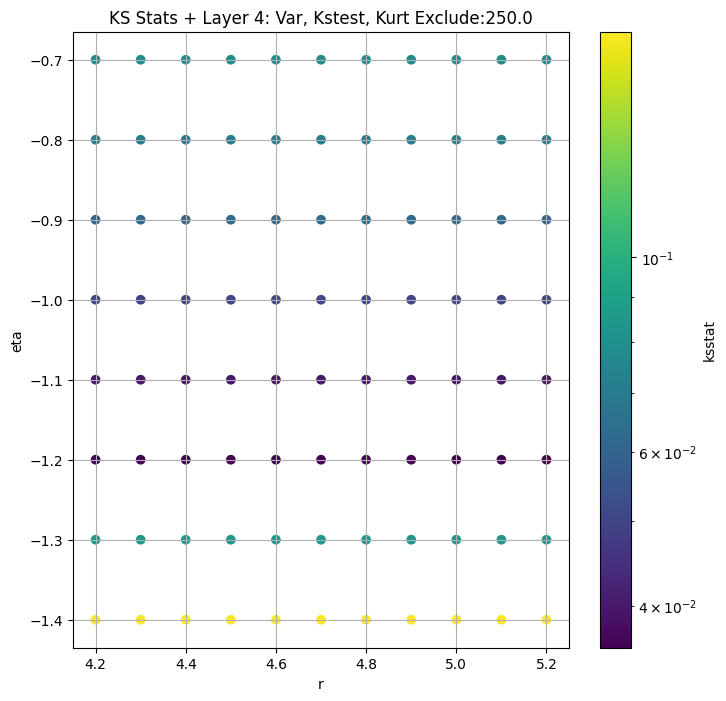

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.053559999999999885 64.06584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.053559999999999885 62.80302


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.053559999999999885 61.781998


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.053559999999999885 60.86087


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.053559999999999885 60.0111


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.053559999999999885 58.46619


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.053559999999999885 57.09659


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.053559999999999885 55.83984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.053559999999999885 54.67095


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.053559999999999885 53.57507


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.053559999999999885 50.636112
Number of samples: 100000, Without approximation : 128384


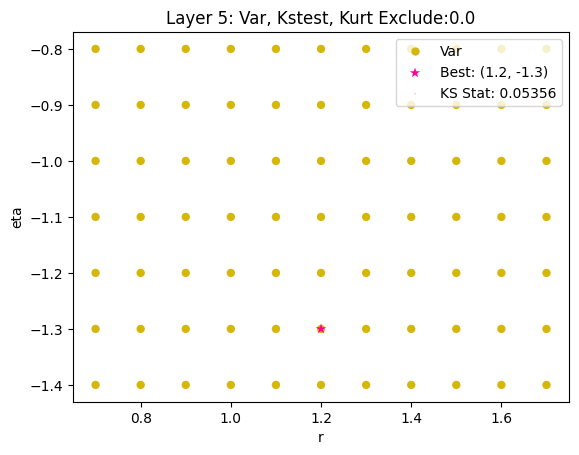

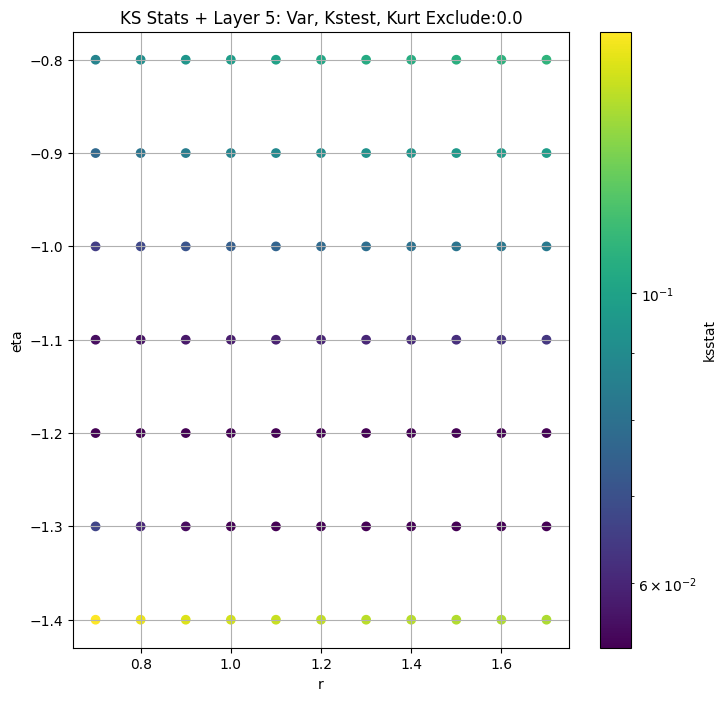

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.08980999999999978 12.431011


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.08980999999999978 12.111617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.08980999999999978 11.857983


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.08980999999999978 11.63291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.08980999999999978 11.427883


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.08980999999999978 11.061025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.08980999999999978 10.734191


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.08980999999999978 10.438063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.08980999999999978 10.164756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.08980999999999978 9.911368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.08980999999999978 9.245201
Number of samples: 100000, Without approximation : 513536


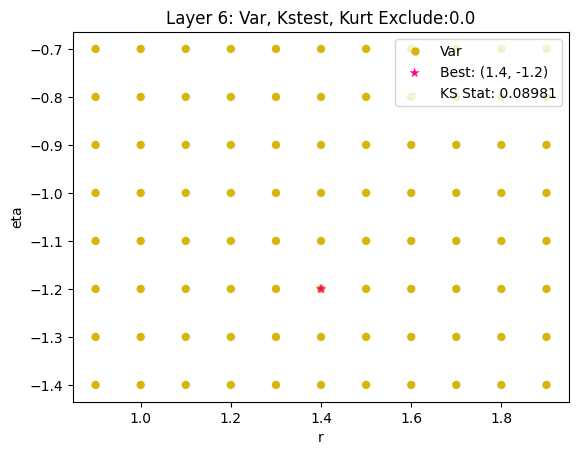

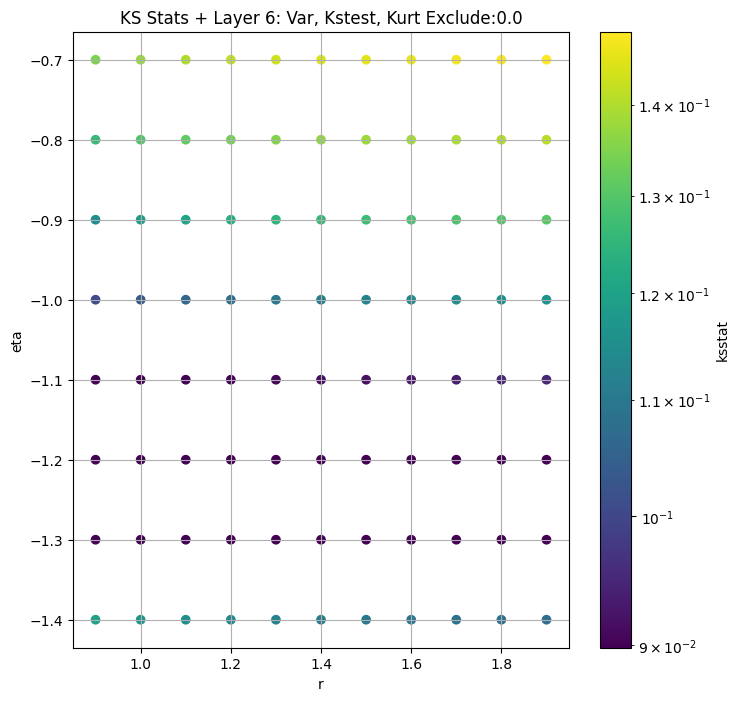

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.12824999999999975 2.5032878


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.12824999999999975 2.42008


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.12824999999999975 2.3569279


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.12824999999999975 2.3015137


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.12824999999999975 2.251527


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.12824999999999975 2.1628833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.12824999999999975 2.0853753


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.12824999999999975 2.0158134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.12824999999999975 1.9524812


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.12824999999999975 1.8941606


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.12824999999999975 1.7422466
Number of samples: 100000, Without approximation : 2054144


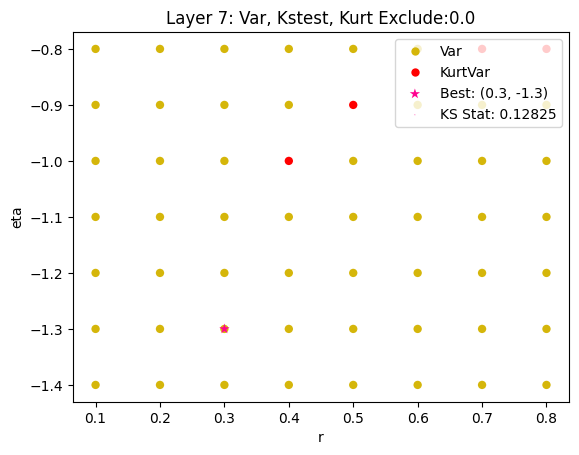

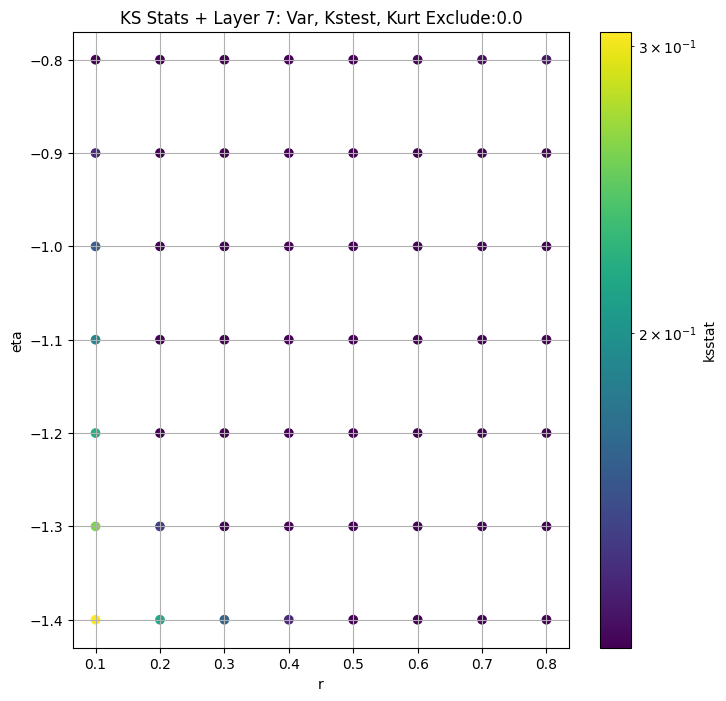

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.16778999999999977 0.58659875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.16778999999999977 0.5649653


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.16778999999999977 0.5482828


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.16778999999999977 0.5338313


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.16778999999999977 0.5208762


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.16778999999999977 0.49812523


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.16778999999999977 0.4783916


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.16778999999999977 0.46083188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.16778999999999977 0.44499195


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.16778999999999977 0.43053254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.16778999999999977 0.39329436
Number of samples: 100000, Without approximation : 8216576


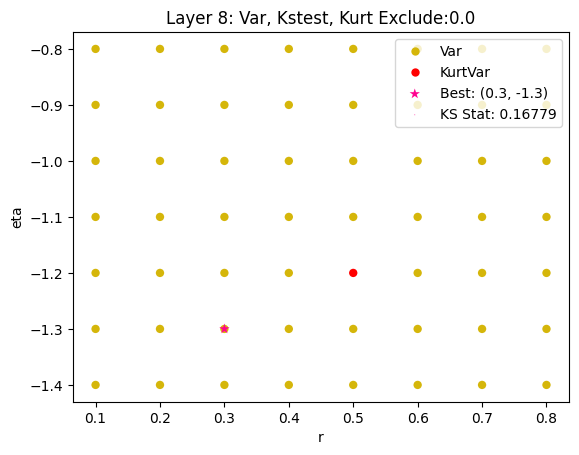

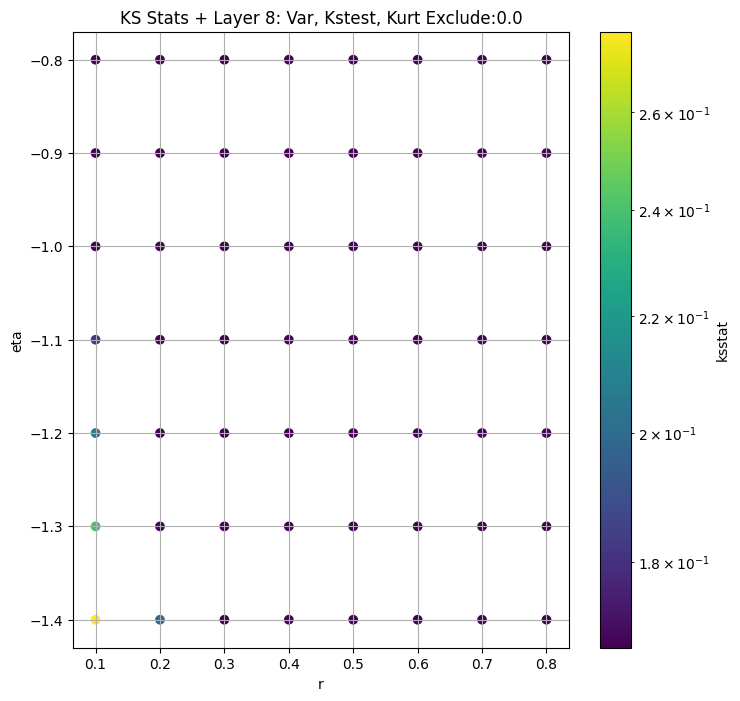

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.2086699999999998 0.19500227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.2086699999999998 0.18824999


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.2086699999999998 0.18285765


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.2086699999999998 0.17816387


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.2086699999999998 0.17396116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.2086699999999998 0.16661185


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.2086699999999998 0.1602792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.2086699999999998 0.1546898


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.2086699999999998 0.14967826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.2086699999999998 0.14513263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.2086699999999998 0.13354085
Number of samples: 100000, Without approximation : 32866304


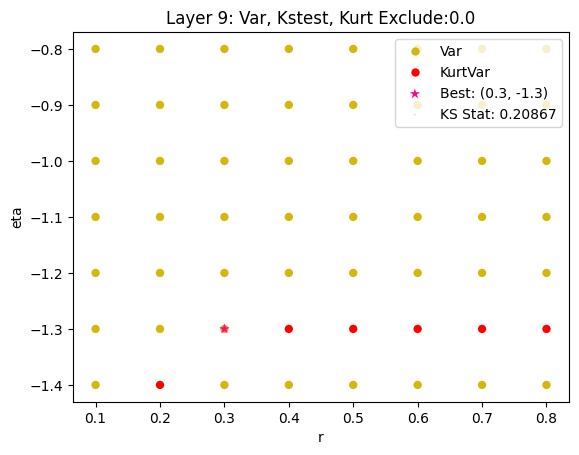

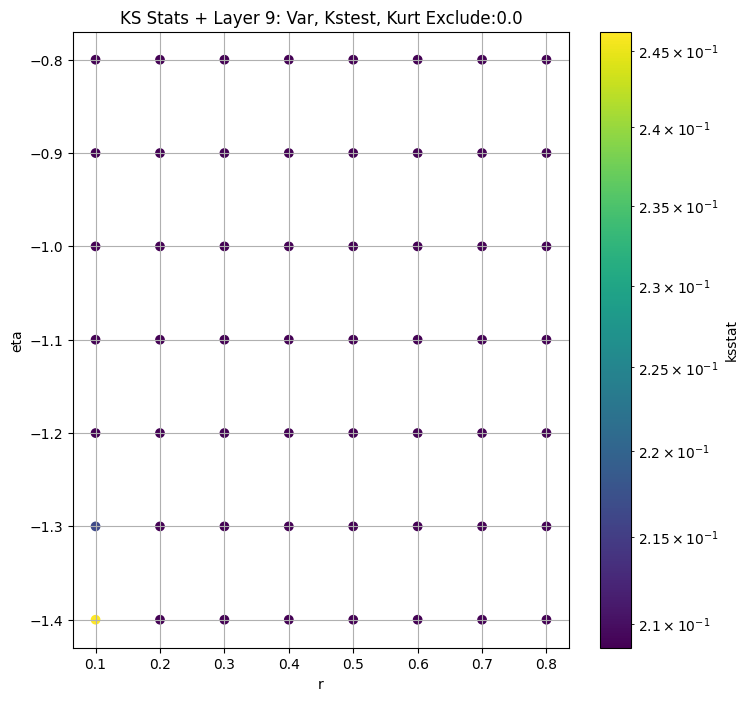

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8463.985000  7577.499500  9384.216000   1.476042    0.959262   
3      1697.862400  1595.025000  1803.665600   2.565592    2.200481   
4       332.164900   311.214750   353.687930   4.184177    3.650794   
5        64.065840    59.352590    68.908600   6.430954    5.621179   
6        12.431011    11.384822    13.536140   9.384012    8.105215   
7         2.503288     2.262330     2.758165  12.938325   10.949556   
8         0.586599     0.525955     0.650404  14.809818   12.432942   
9         0.195002     0.176042     0.215174  13.231615   11.041210   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.113501           2006             0.045380        1.8         -0.6   
3        2.955890           8024             0.043553        1.3         -1.0   
4        4.750882          32096             0.035856        4.7         -1.2   
5        7.308013         128384             0.053560        1.2         -1.3   
6       10.801366         513536             0.089810        1.4         -1.2   
7       15.221071        2054144             0.128250        0.3         -1.3   
8       17.457571        8216576             0.167790        0.3         -1.3   
9       15.557378       32866304             0.208670        0.3         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       15452.647964                     0.0         8463.985000   
3        4208.027404                     0.0         1697.862400   
4        1191.244537                   250.0          256.238220   
5         356.610720                     0.0           64.065840   
6          50.687800                     0.0           12.431011   
7           0.564958                     0.0            2.503288   
8           0.132387                     0.0            0.586599   
9           0.044009                     0.0            0.195002   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.030238  
3                     0.015140  
4                     0.007575  
5                     0.003789  
6                     0.001895  
7                     0.000947  
8                     0.000474  
9                     0.000237

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.0938265624856991, var: 4228.98583984375


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.08052938230094453, var: 4822.39453125


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.06539868128799331, var: 5587.20361328125


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.04983454096921469, var: 6644.865234375


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.04518300132804737, var: 8463.9853515625
Number of samples: 2006, Without approximation : 2006


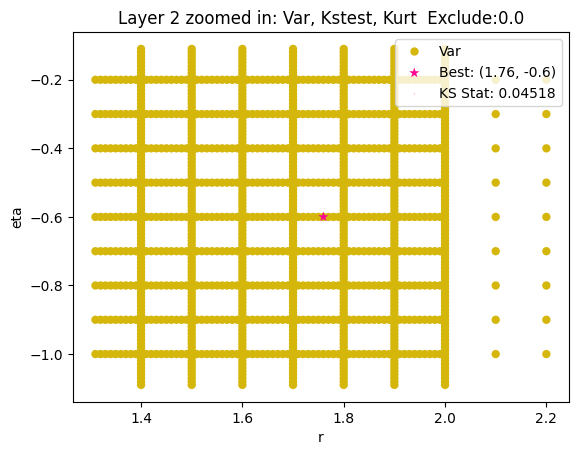

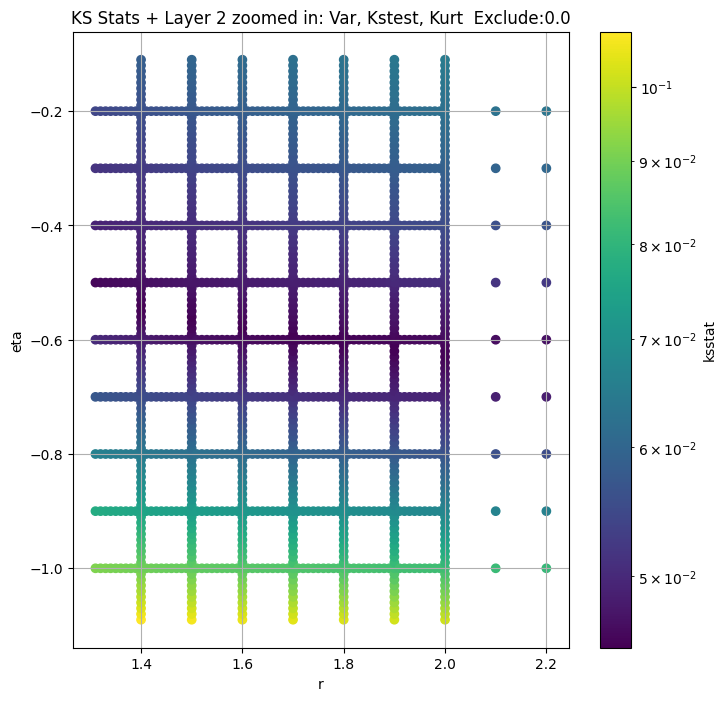

Layer 3


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.044921566264050417, var: 1261.018798828125


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.044180149719535045, var: 1339.2474365234375


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.04378927134821231, var: 1427.692626953125


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.043411333930873264, var: 1536.1680908203125


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.043149330282695464, var: 1697.8624267578125
Number of samples: 8024, Without approximation : 8024


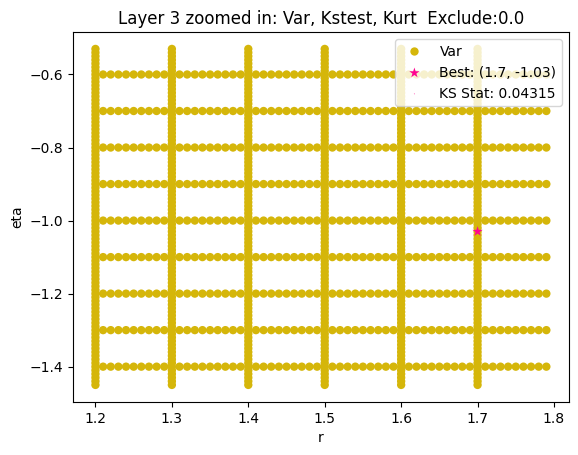

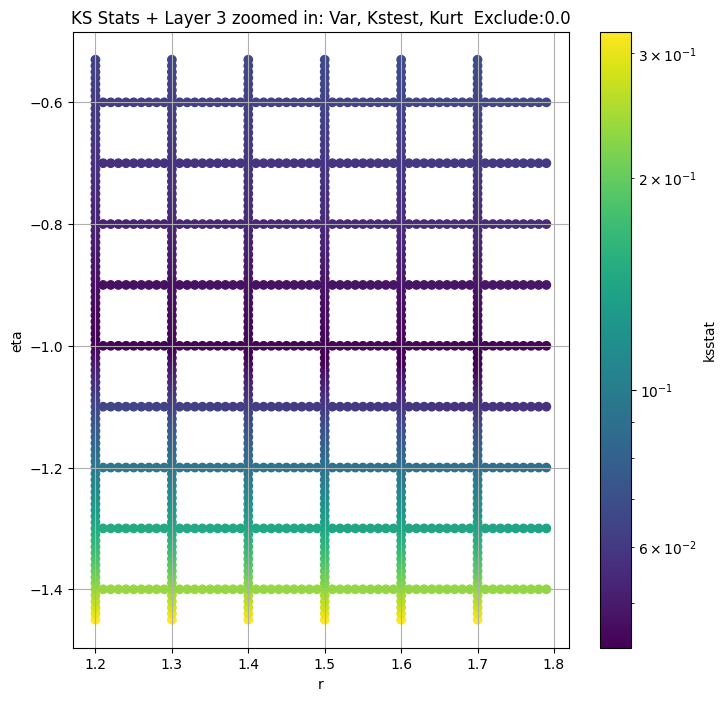

Layer 4


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 250.0 + 100 = 350, ksstat: 0.03633710347022201, var: 237.50869750976562


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 250.0 + 75 = 325, ksstat: 0.03634962293923577, var: 241.94326782226562


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 250.0 + 50 = 300, ksstat: 0.03636227258739777, var: 246.55105590820312


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 250.0 + 25 = 275, ksstat: 0.036374960551680546, var: 251.30606079101562


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 250.0 + 0 = 250, ksstat: 0.035855511864019196, var: 256.23822021484375


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 250.0 + -25 = 225, ksstat: 0.035856005026547955, var: 261.3610534667969


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 250.0 + -50 = 200, ksstat: 0.035856694249891796, var: 266.783447265625


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 250.0 + -75 = 175, ksstat: 0.03585791062862409, var: 272.4844665527344


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 250.0 + -100 = 150, ksstat: 0.03586035414132882, var: 278.6024169921875
Number of samples: 32096, Without approximation : 32096


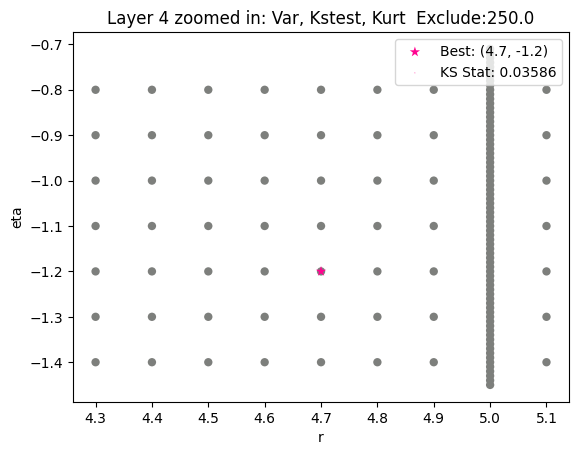

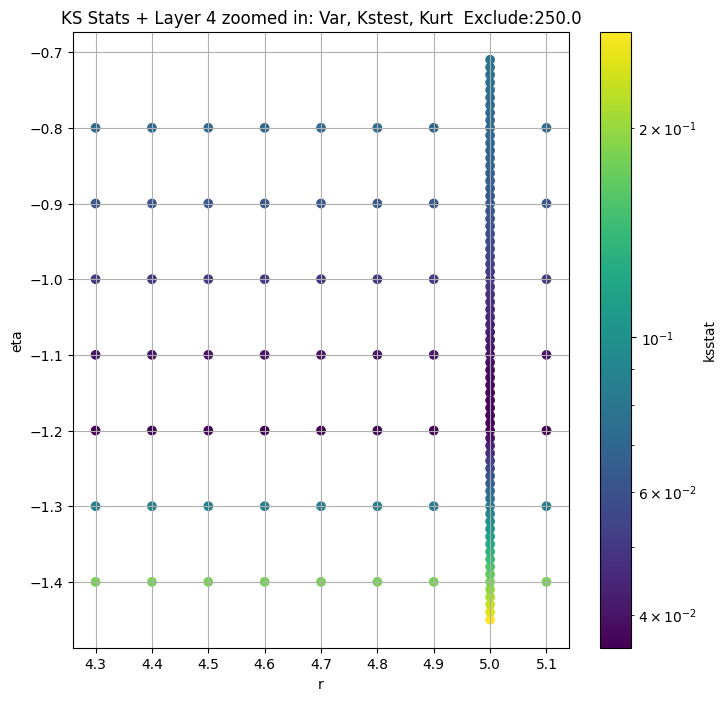

Layer 5


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.053559999999999774, var: 60.01110076904297


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.053559999999999774, var: 60.860870361328125


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.053559999999999774, var: 61.78199768066406


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.053559999999999774, var: 62.80302047729492


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.053559999999999774, var: 64.06584167480469
Number of samples: 100000, Without approximation : 128384


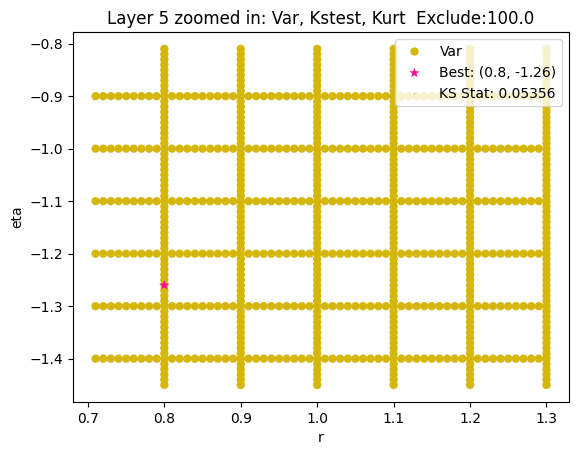

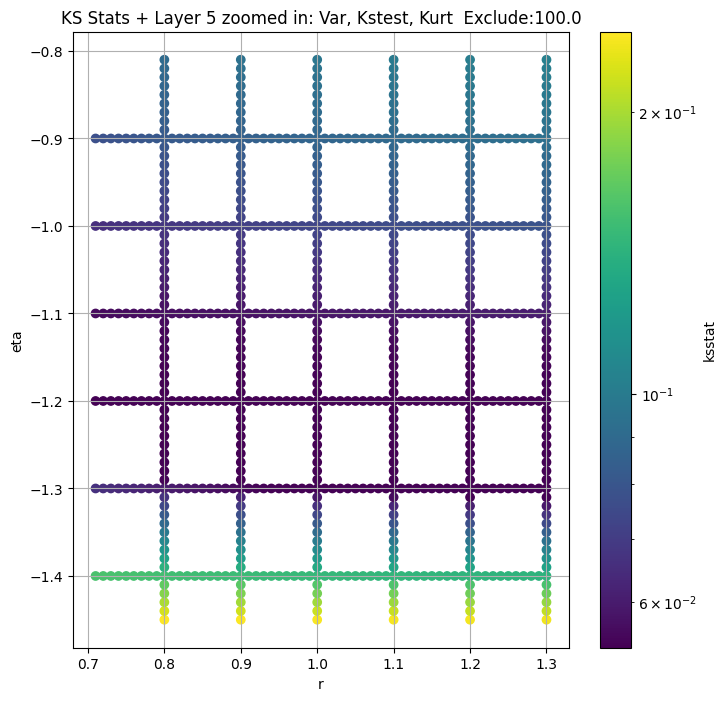

Layer 6


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.08980999999999972, var: 11.42788314819336


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.08980999999999972, var: 11.632909774780273


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.08980999999999972, var: 11.857982635498047


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.08980999999999972, var: 12.111617088317871


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.08980999999999972, var: 12.431011199951172
Number of samples: 100000, Without approximation : 513536


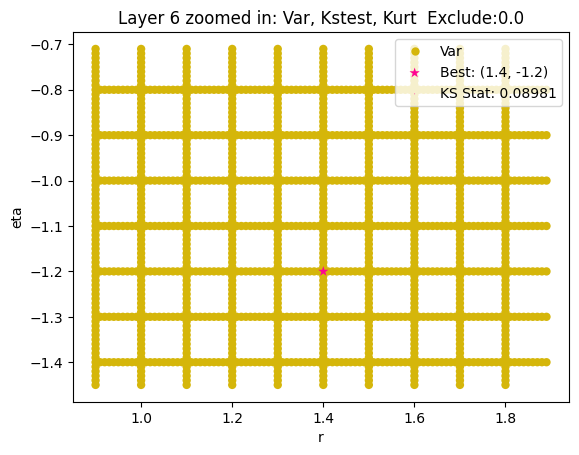

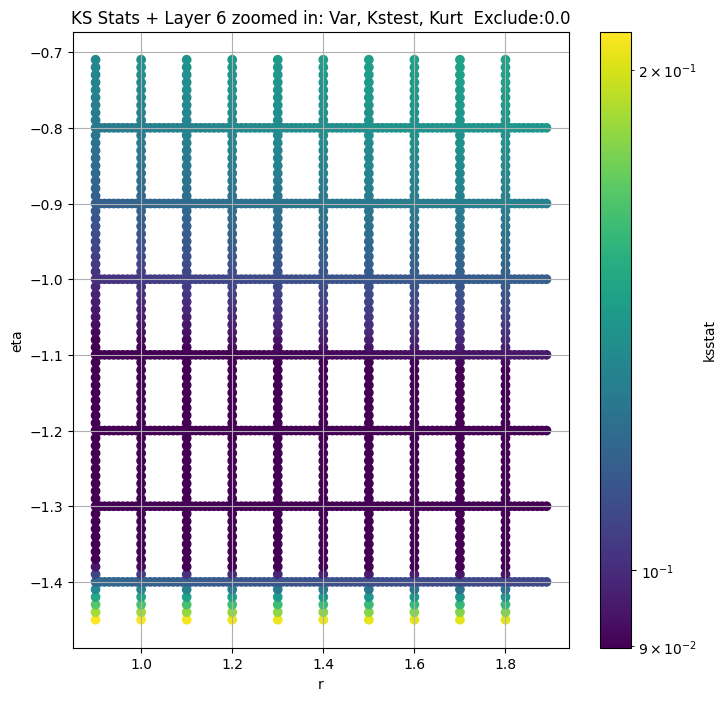

Layer 7


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.12824999999999975, var: 2.2515270709991455


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.12824999999999975, var: 2.301513671875


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.12824999999999975, var: 2.3569278717041016


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.12824999999999975, var: 2.4200799465179443


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.12824999999999975, var: 2.5032877922058105
Number of samples: 100000, Without approximation : 2054144


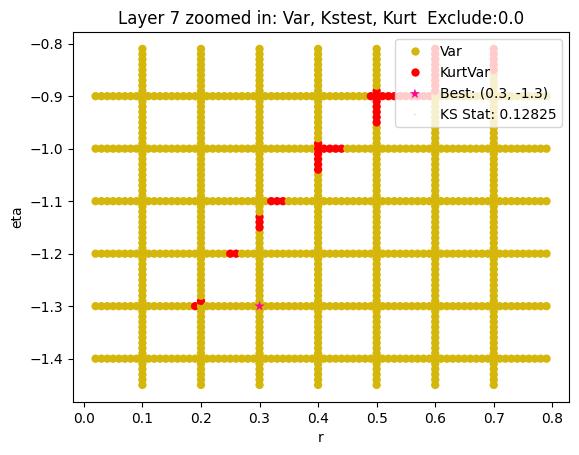

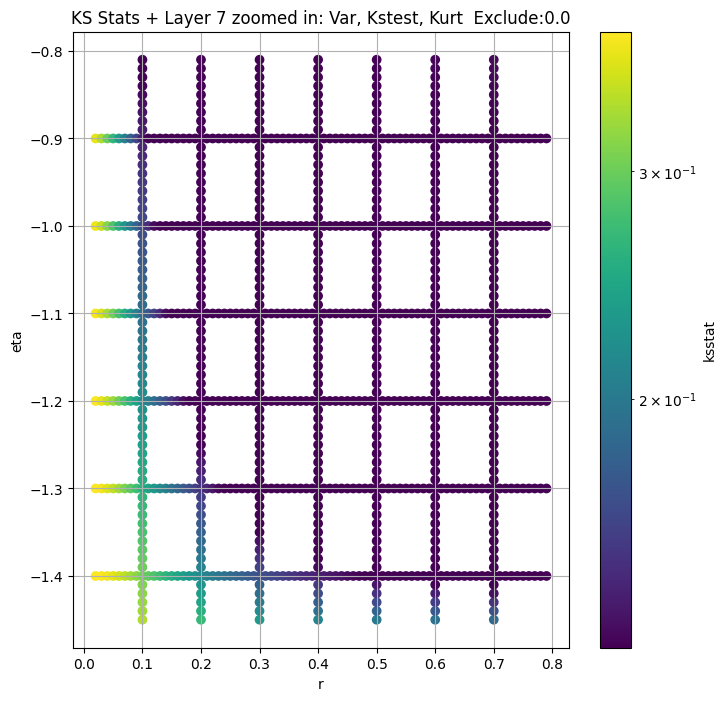

Layer 8


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.16778999999999977, var: 0.5208762288093567


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.16778999999999977, var: 0.5338312983512878


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.16778999999999977, var: 0.54828280210495


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.16778999999999977, var: 0.5649653077125549


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.16778999999999977, var: 0.5865987539291382
Number of samples: 100000, Without approximation : 8216576


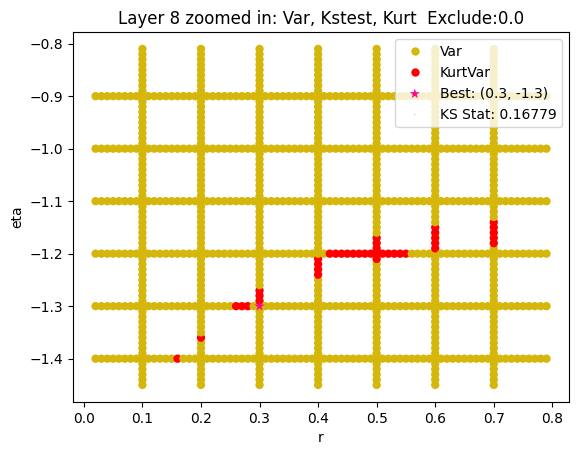

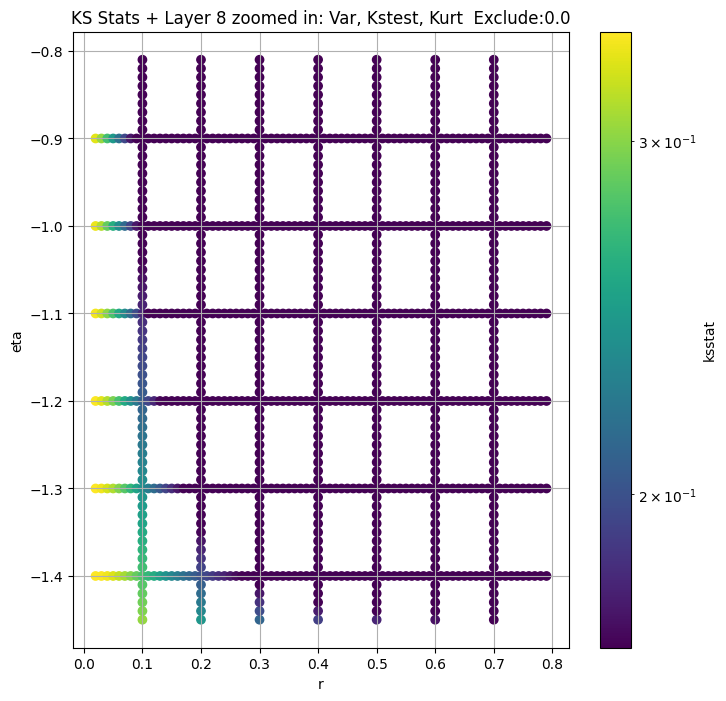

Layer 9


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.2086699999999998, var: 0.17396116256713867


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.2086699999999998, var: 0.17816387116909027


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.2086699999999998, var: 0.18285764753818512


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.2086699999999998, var: 0.18824999034404755


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.2086699999999998, var: 0.19500227272510529
Number of samples: 100000, Without approximation : 32866304


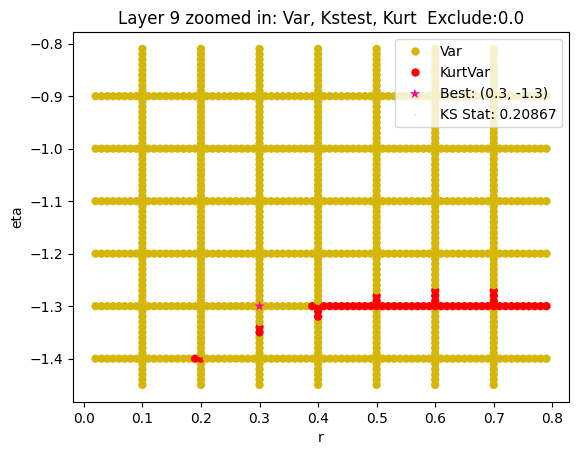

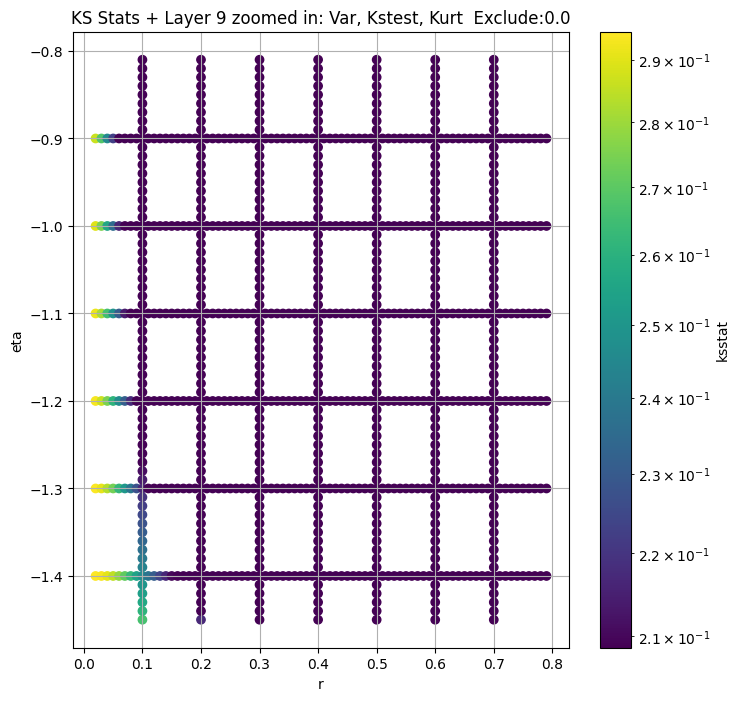

Not a fit


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8463.985000  7577.499500  9384.216000   1.476042    0.959262   
3      1697.862400  1595.025000  1803.665600   2.565592    2.200481   
4       332.164900   311.214750   353.687930   4.184177    3.650794   
5        64.065840    59.352590    68.908600   6.430954    5.621179   
6        12.431011    11.384822    13.536140   9.384012    8.105215   
7         2.503288     2.262330     2.758165  12.938325   10.949556   
8         0.586599     0.525955     0.650404  14.809818   12.432942   
9         0.195002     0.176042     0.215174  13.231615   11.041210   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.113501           2006             0.045380        1.8         -0.6   
3        2.955890           8024             0.043553        1.3         -1.0   
4        4.750882          32096             0.035856        4.7         -1.2   
5        7.308013         128384             0.053560        1.2         -1.3   
6       10.801366         513536             0.089810        1.4         -1.2   
7       15.221071        2054144             0.128250        0.3         -1.3   
8       17.457571        8216576             0.167790        0.3         -1.3   
9       15.557378       32866304             0.208670        0.3         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       15452.647964                     0.0         8463.985352   
3        4208.027404                     0.0         1697.862427   
4        1191.244537                   250.0          256.238220   
5         356.610720                     0.0           60.011101   
6          50.687800                     0.0           12.431011   
7           0.564958                     0.0            2.503288   
8           0.132387                     0.0            0.586599   
9           0.044009                     0.0            0.195002   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.030238          0.045183    1.76     -0.60   
3                     0.015140          0.043149    1.70     -1.03   
4                     0.007575          0.035856    4.70     -1.20   
5                     0.003789          0.053560    0.80     -1.26   
6                     0.001895          0.089810    1.40     -1.20   
7                     0.000947          0.128250    0.30     -1.30   
8                     0.000474          0.167790    0.30     -1.30   
9                     0.000237          0.208670    0.30     -1.30   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      15288.321639                  0.0          949  
3       5037.457067                  0.0         1003  
4       1191.244537                250.0         1504  
5        201.972934                100.0          631  
6         50.687800                  0.0          235  
7          0.564958                  0.0          115  
8          0.132387                  0.0           62  
9          0.044009                  0.0           -1

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

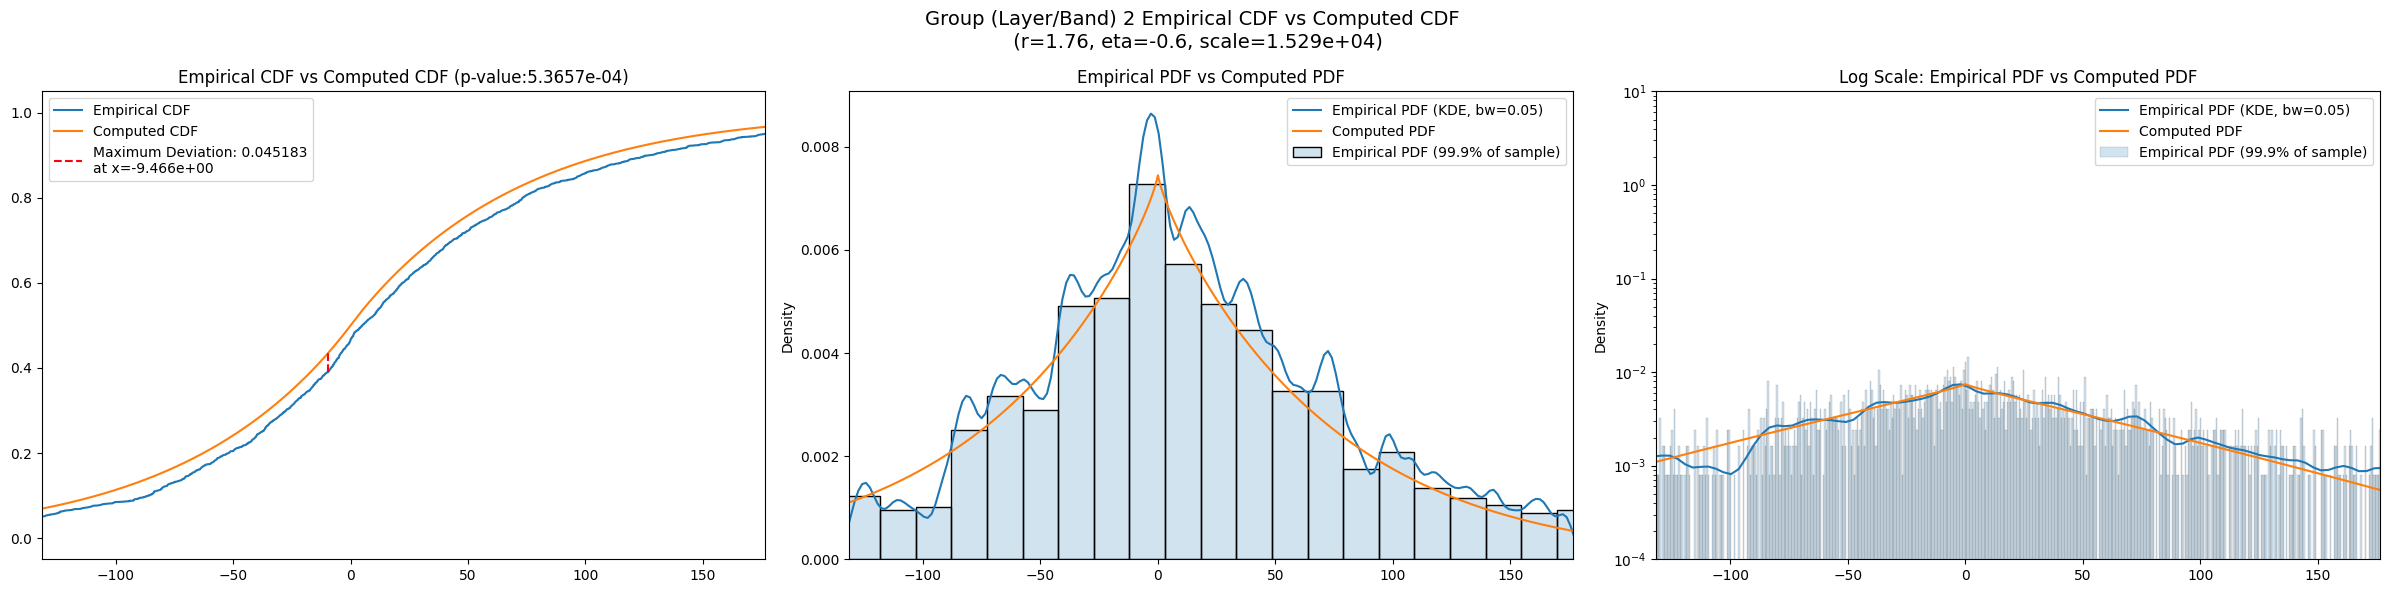

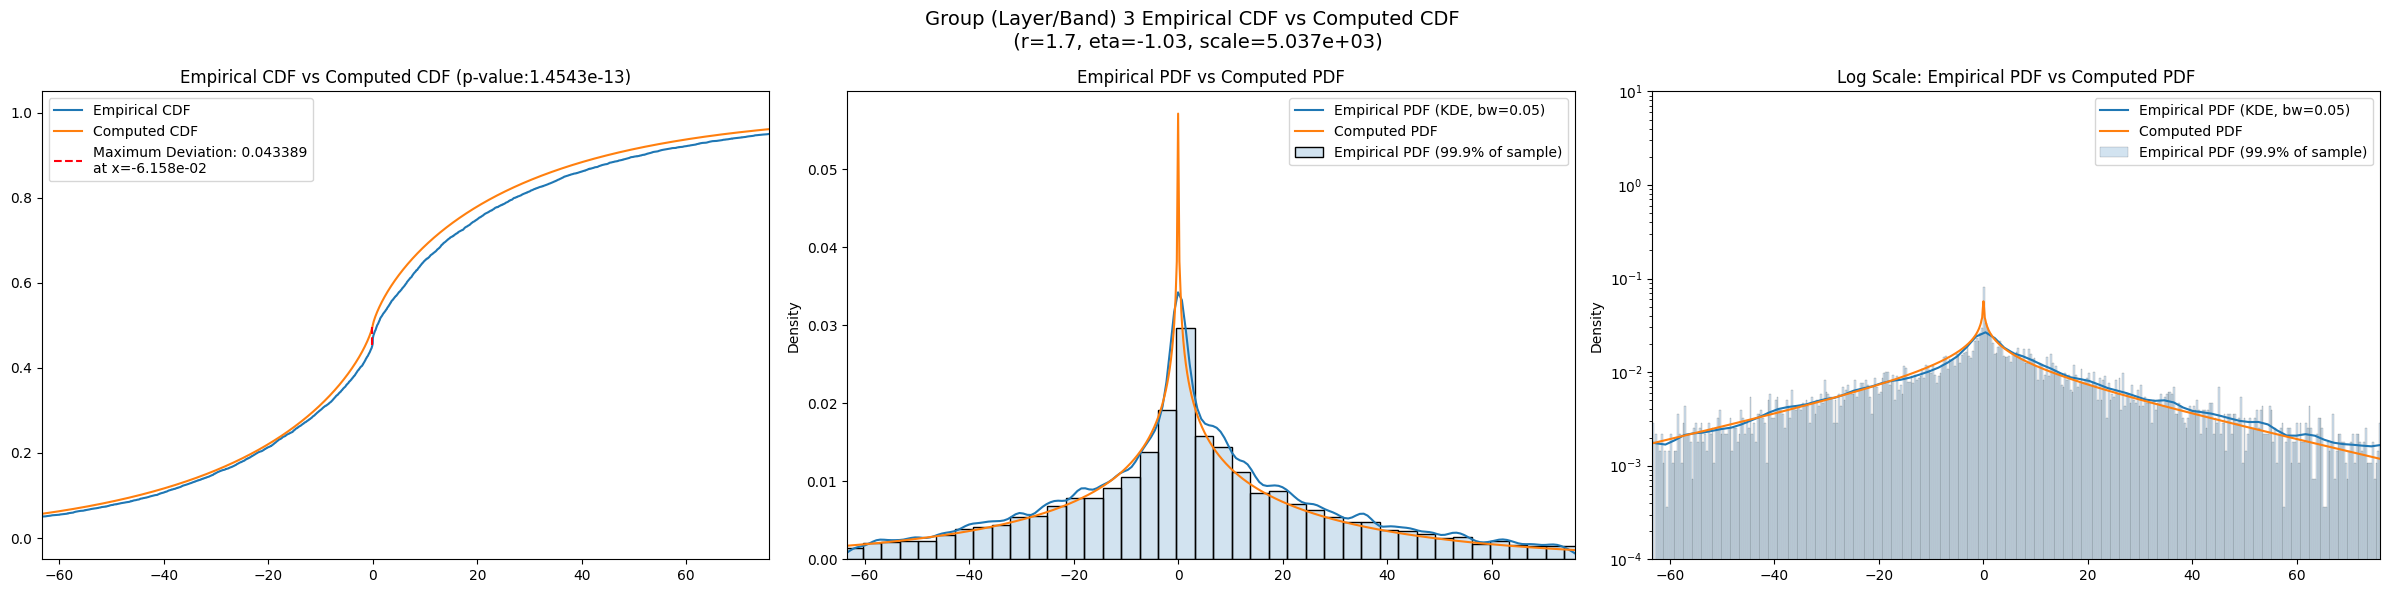

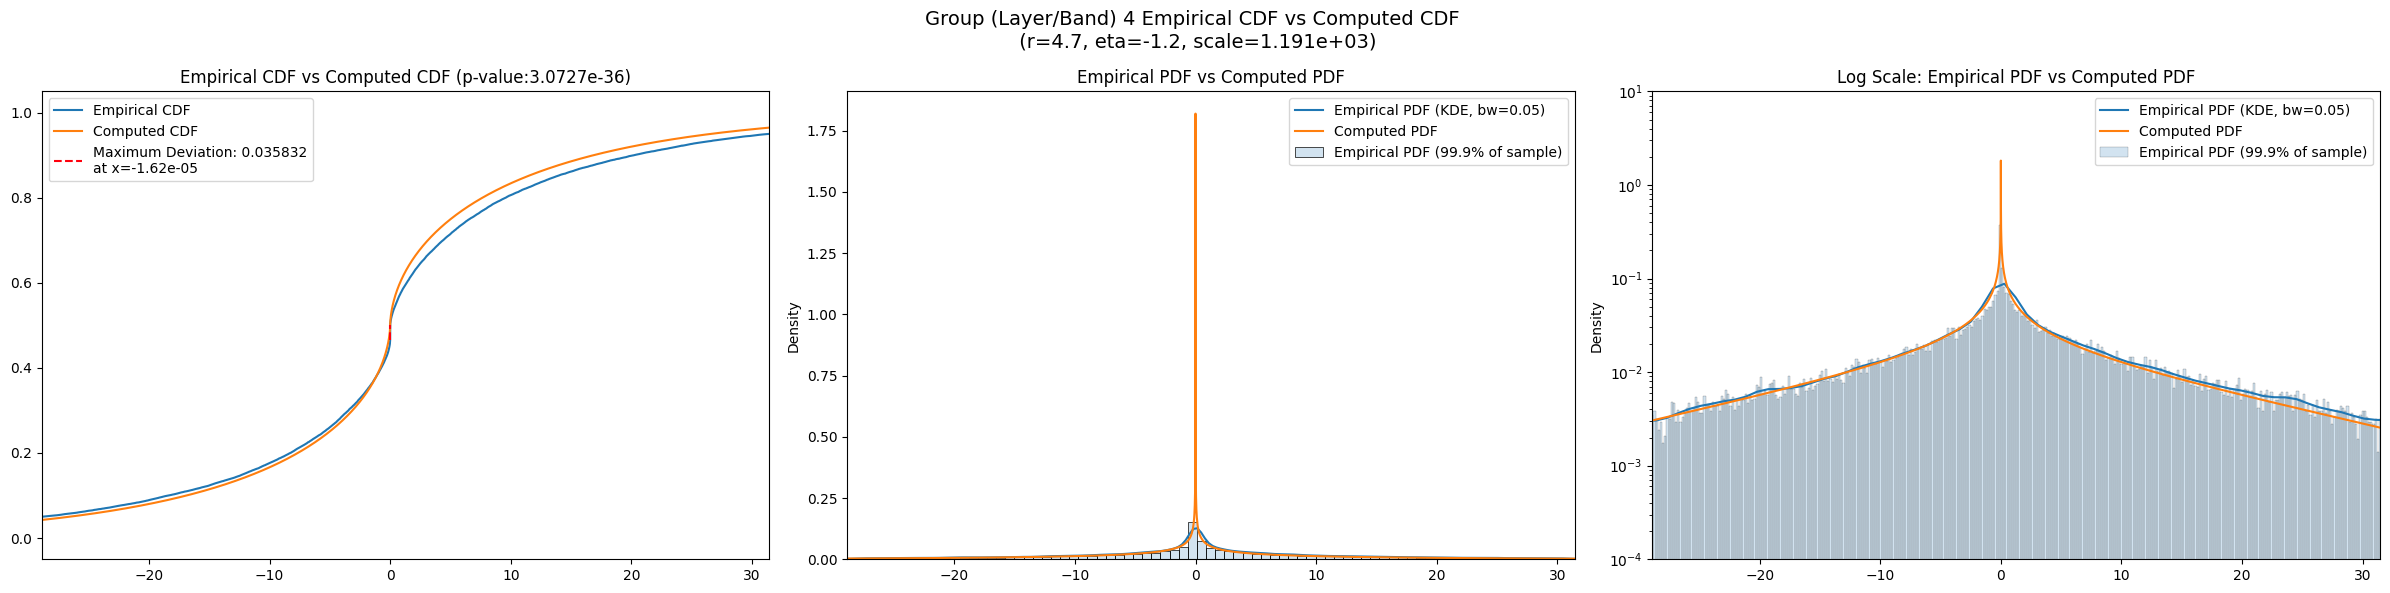

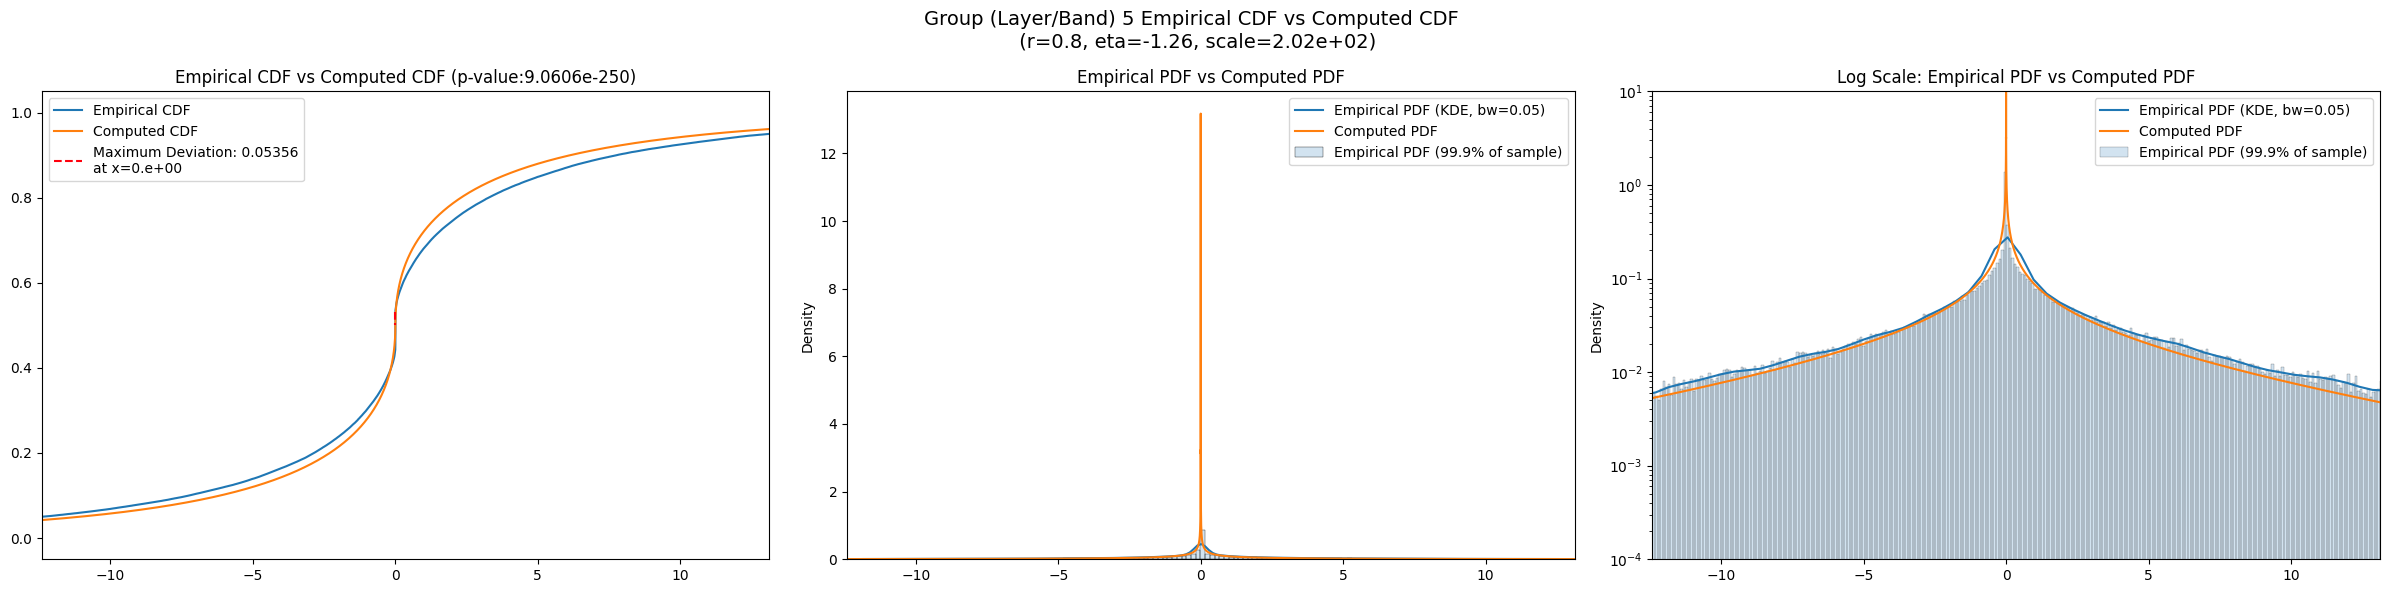

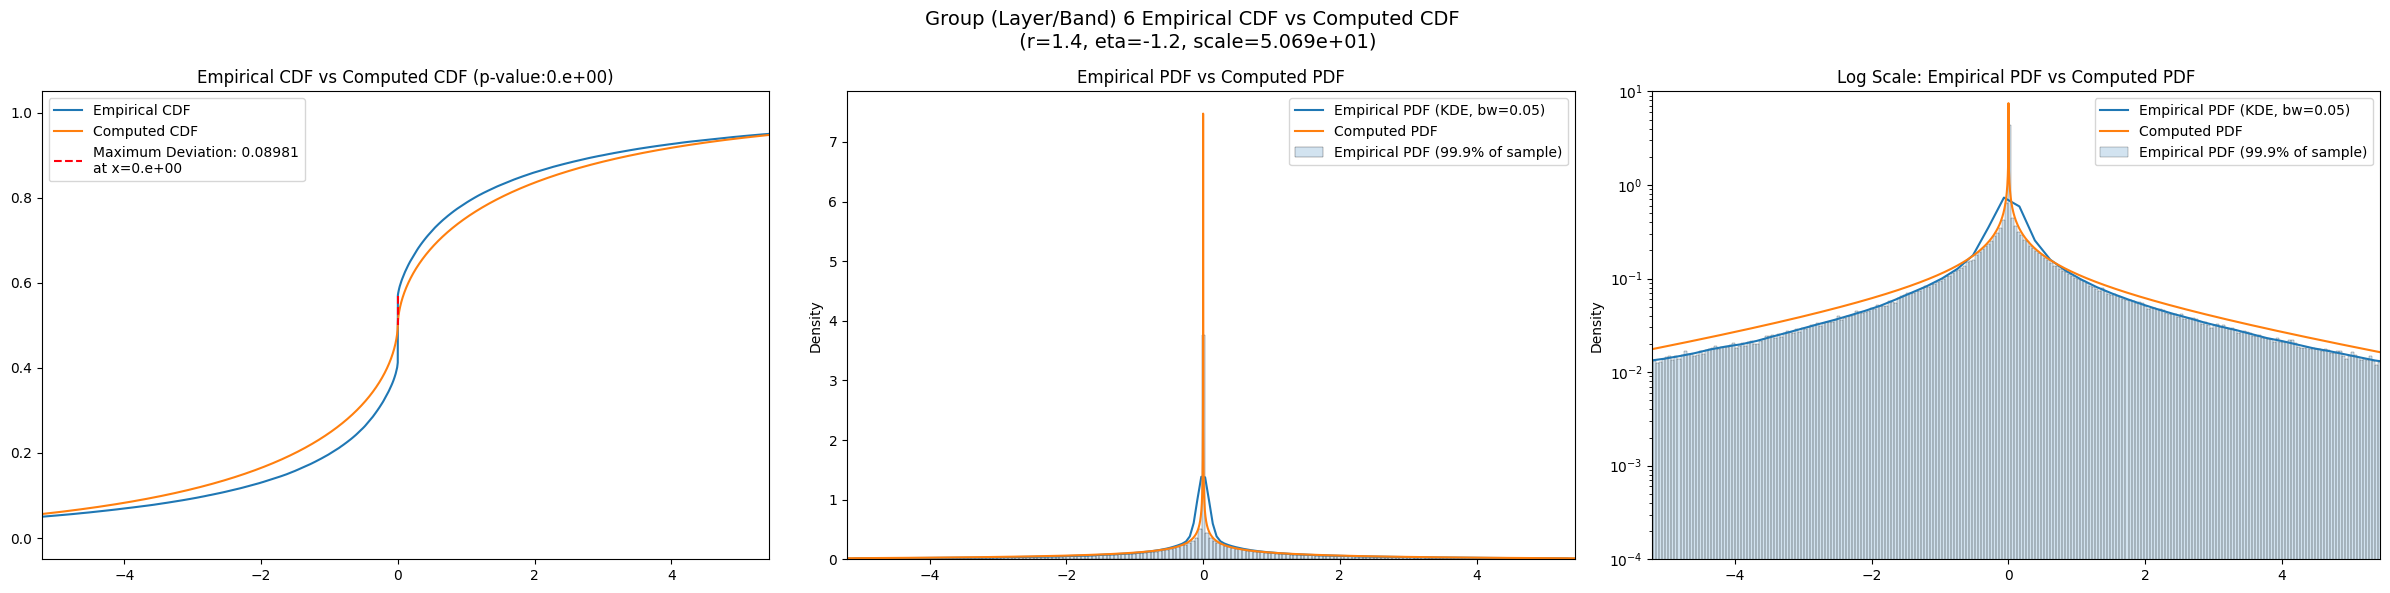

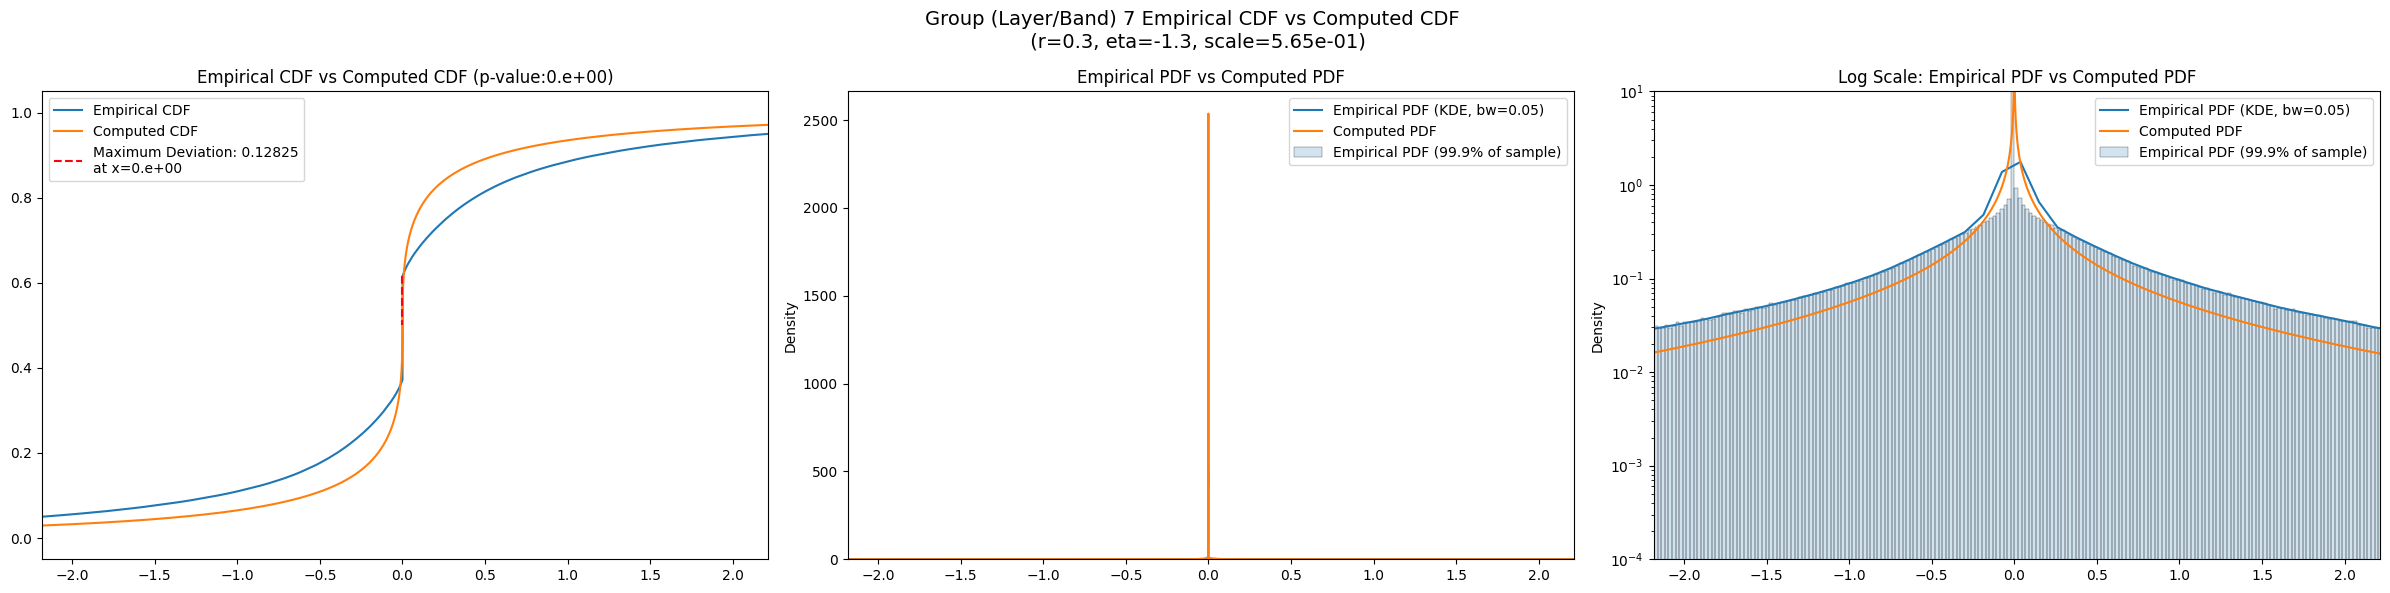

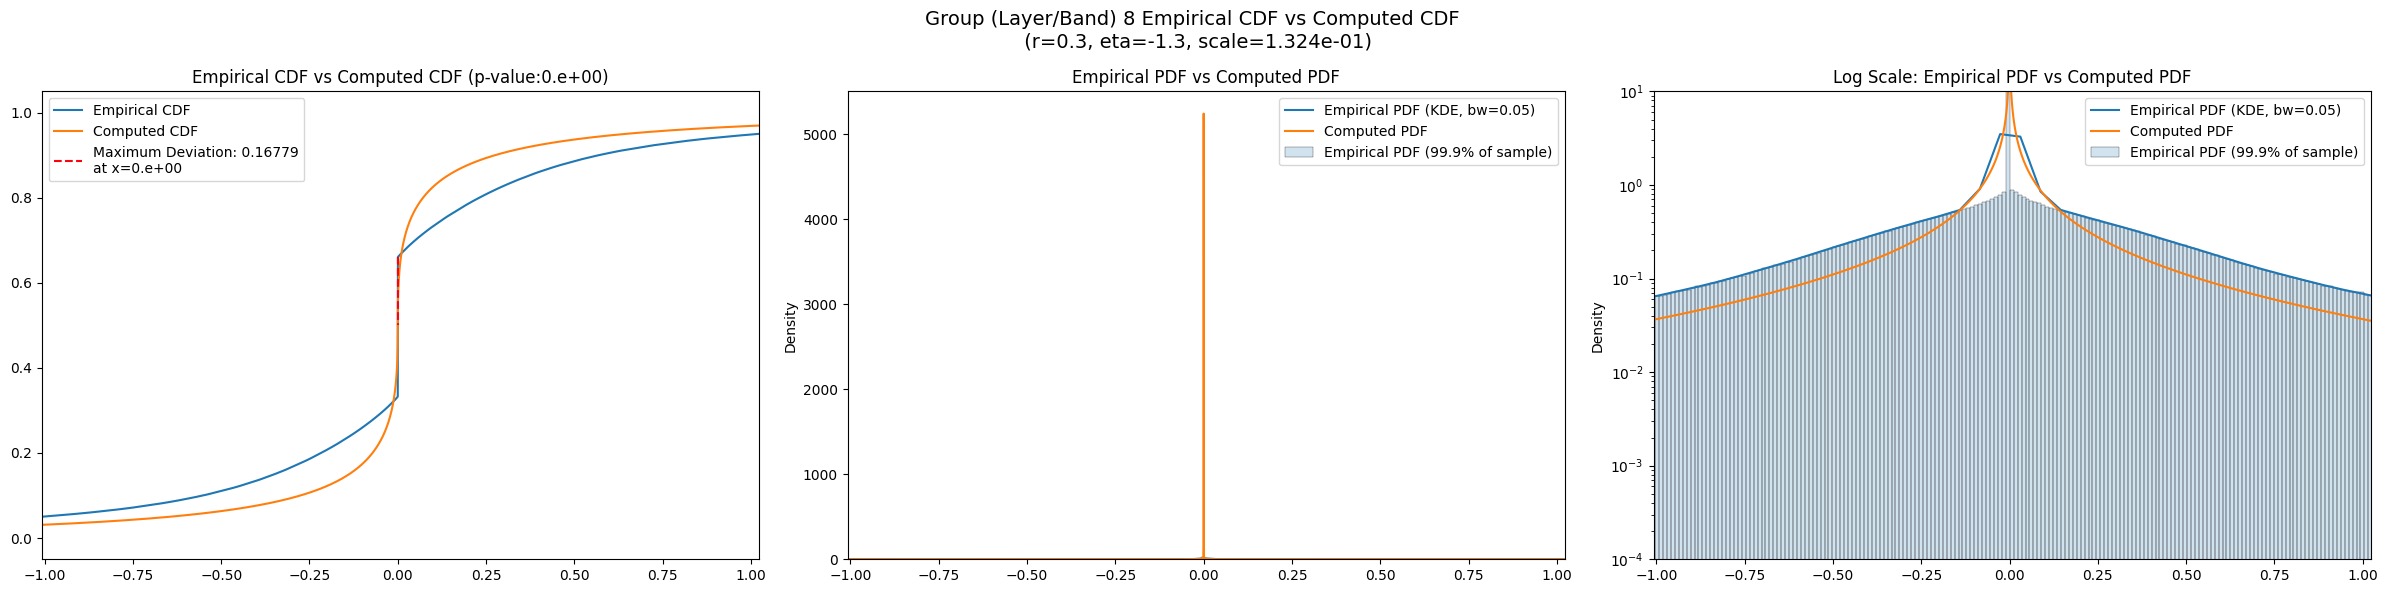

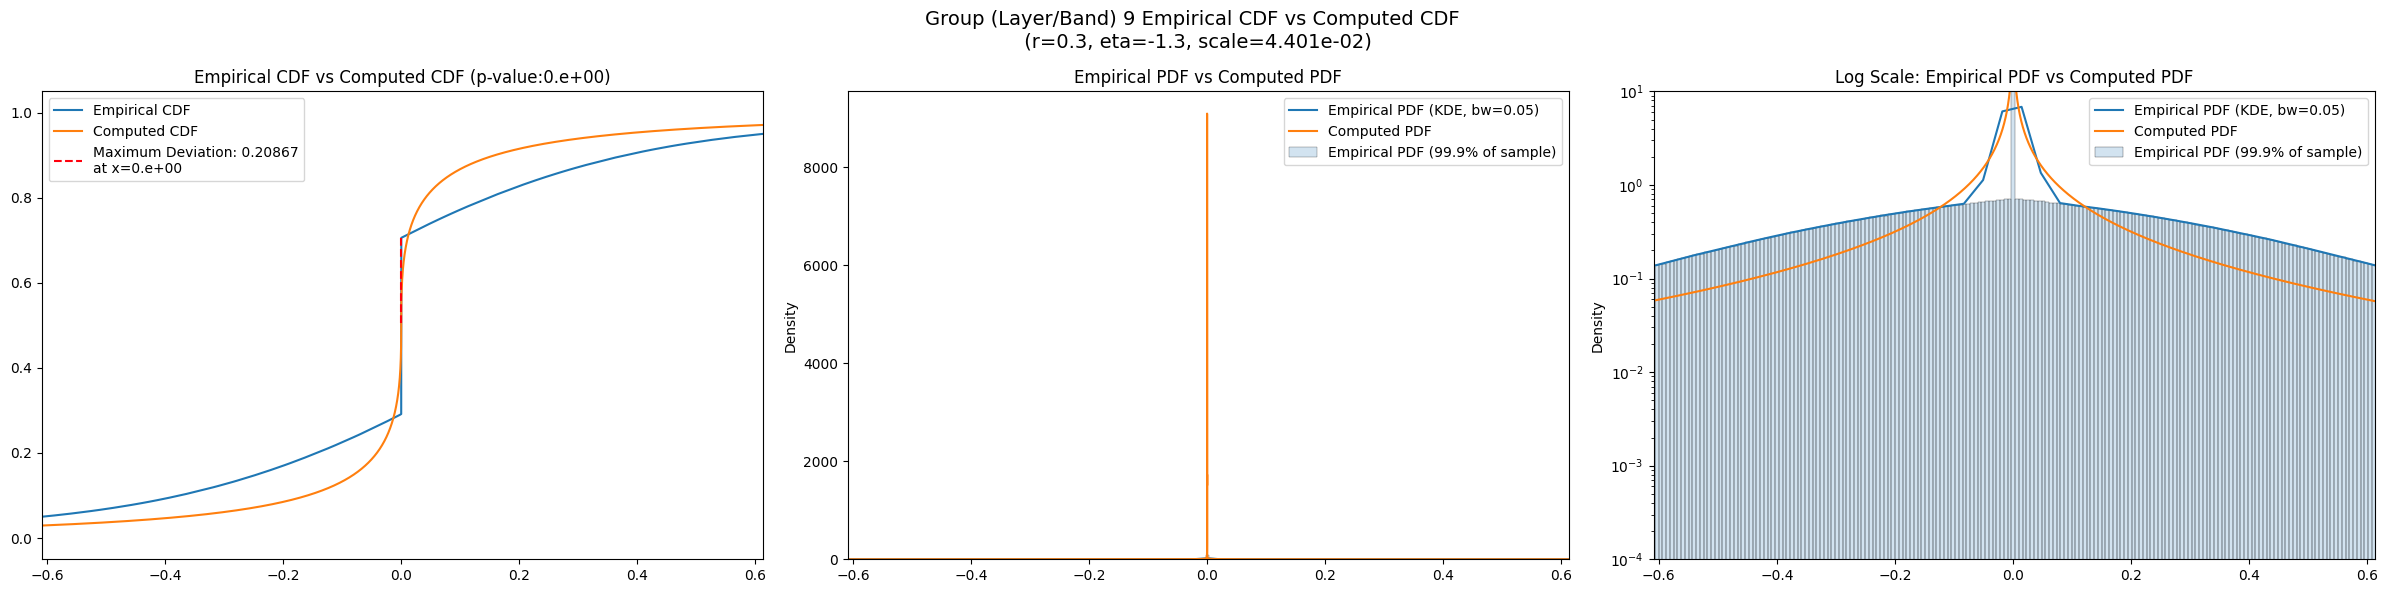

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      8463.985000  7577.499500  9384.216000   1.476042    0.959262   
3      1697.862400  1595.025000  1803.665600   2.565592    2.200481   
4       332.164900   311.214750   353.687930   4.184177    3.650794   
5        64.065840    59.352590    68.908600   6.430954    5.621179   
6        12.431011    11.384822    13.536140   9.384012    8.105215   
7         2.503288     2.262330     2.758165  12.938325   10.949556   
8         0.586599     0.525955     0.650404  14.809818   12.432942   
9         0.195002     0.176042     0.215174  13.231615   11.041210   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.113501           2006             0.045380        1.8         -0.6   
3        2.955890           8024             0.043553        1.3         -1.0   
4        4.750882          32096             0.035856        4.7         -1.2   
5        7.308013         128384             0.053560        1.2         -1.3   
6       10.801366         513536             0.089810        1.4         -1.2   
7       15.221071        2054144             0.128250        0.3         -1.3   
8       17.457571        8216576             0.167790        0.3         -1.3   
9       15.557378       32866304             0.208670        0.3         -1.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       73.844900              0.059981          1.024870e-06   
3      ...       27.808800              0.069160          8.140160e-34   
4      ...       10.193000              0.077674         7.181540e-169   
5      ...        3.400080              0.092545          0.000000e+00   
6      ...        1.108030              0.107806          0.000000e+00   
7      ...        0.348582              0.128319          0.000000e+00   
8      ...        0.126977              0.167793          0.000000e+00   
9      ...        0.050011              0.208676          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          68.562400             0.045190         5.351850e-04  55.669300   
3          22.990100             0.052848         6.433270e-20  19.188800   
4           8.341220             0.057860         7.676720e-94   6.759090   
5           2.737090             0.074289         0.000000e+00   2.182330   
6           0.834404             0.095733         0.000000e+00   0.652774   
7           0.254636             0.128250         0.000000e+00   0.190353   
8           0.096934             0.167790         0.000000e+00   0.073706   
9           0.030953             0.208673         0.000000e+00   0.021418   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.049980   8.551700e-05          5.365683e-04  
3           0.057743   1.070070e-23          2.028343e-13  
4           0.061730  9.129600e-107          2.753581e-36  
5           0.077143   0.000000e+00                   NaN  
6           0.097229   0.000000e+00          0.000000e+00  
7           0.128250   0.000000e+00          0.000000e+00  
8           0.167790   0.000000e+00          0.000000e+00  
9           0.208673   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.045380                 0.030238          0.045183   
3                 0.043553                 0.015140          0.043149   
4                 0.035856                 0.007575          0.035856   
5                 0.053560                 0.003789          0.053560   
6                 0.089810                 0.001895          0.089810   
7                 0.128250                 0.000947          0.128250   
8                 0.167790                 0.000474          0.167790   
9                 0.208670                 0.000237          0.208670   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.059981             0.045190       0.049980  
3                  0.069160             0.052848       0.057743  
4                  0.077674             0.057860       0.061730  
5                  0.092545             0.074289       0.077143  
6                  0.107806             0.095733       0.097229  
7                  0.128319             0.128250       0.128250  
8                  0.167793             0.167790       0.167790  
9                  0.208676             0.208673       0.208673

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             8463.985352          0.045183    1.76     -0.60  15288.321639   
3             1697.862427          0.043149    1.70     -1.03   5037.457067   
4              256.238220          0.035856    4.70     -1.20   1191.244537   
5               60.011101          0.053560    0.80     -1.26    201.972934   
6               12.431011          0.089810    1.40     -1.20     50.687800   
7                2.503288          0.128250    0.30     -1.30      0.564958   
8                0.586599          0.167790    0.30     -1.30      0.132387   
9                0.195002          0.208670    0.30     -1.30      0.044009   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                    250.0  
5                    100.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0

In [21]:
eng.quit()